In [2]:
import numpy as np

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Adilbai/stock-dataset")
df = dataset["train"].to_pandas()

In [4]:
TICKER = "AAPL"

# Filter to one stock
df_aapl = df[df["Ticker"] == TICKER].copy()

# Sort by date (CRITICAL)
df_aapl = df_aapl.sort_values("Date").reset_index(drop=True)

print(df_aapl.shape)
print(df_aapl[["Date", "Close"]].head())
print(df_aapl[["Date", "Close"]].tail())

(1245, 73)
                        Date      Close
0  2020-07-15 00:00:00-04:00  94.995468
1  2020-07-16 00:00:00-04:00  93.826546
2  2020-07-17 00:00:00-04:00  93.636978
3  2020-07-20 00:00:00-04:00  95.610291
4  2020-07-21 00:00:00-04:00  94.290703
                           Date       Close
1240  2025-06-23 00:00:00-04:00  201.500000
1241  2025-06-24 00:00:00-04:00  200.300003
1242  2025-06-25 00:00:00-04:00  201.559998
1243  2025-06-26 00:00:00-04:00  201.000000
1244  2025-06-27 00:00:00-04:00  201.080002


In [5]:
INPUT_FEATURES = [
    # Price & volume
    "Open", "High", "Low", "Close", "Volume",

    # Trend
    "SMA_5", "SMA_10", "SMA_20", "SMA_50",
    "EMA_12", "EMA_26",

    # Momentum
    "MACD", "MACD_Signal", "MACD_Histogram",
    "RSI",

    # Volatility / bands
    "BB_Width", "BB_Position", "Volatility",

    # Ratios
    "High_Low_Ratio", "Open_Close_Ratio",
    "Volume_SMA", "Volume_Ratio",

    # Lags (short only)
    "Close_lag_1", "Close_lag_2", "Close_lag_3", "Close_lag_5",
    "Volume_lag_1", "Volume_lag_2", "Volume_lag_3",
    "Price_Change_lag_1", "Price_Change_lag_2", "Price_Change_lag_3",
    "RSI_lag_1", "RSI_lag_2",
    "MACD_lag_1", "MACD_lag_2",
    "Volatility_lag_1", "Volatility_lag_2",
]


In [6]:
TARGET = "Future_Return_5d"

df_model = df_aapl[INPUT_FEATURES + [TARGET]].dropna().reset_index(drop=True)

print(df_model[TARGET].describe())

count    1245.000000
mean        0.003877
std         0.040909
min        -0.227474
25%        -0.020778
50%         0.003420
75%         0.028389
max         0.184141
Name: Future_Return_5d, dtype: float64


In [7]:
train_frac = 0.8

n = len(df_model)
train_end = int(n * train_frac)

train_df = df_model.iloc[:train_end]
test_df  = df_model.iloc[train_end:]

print(len(train_df), len(test_df))

996 249


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(train_df[INPUT_FEATURES])
X_test  = scaler.transform(test_df[INPUT_FEATURES])

y_train = train_df[TARGET].values
y_test  = test_df[TARGET].values

In [9]:
SEQ_LEN = 10

def make_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = make_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq   = make_sequences(X_test, y_test, SEQ_LEN)

print(X_train_seq.shape, y_train_seq.shape)


(986, 10, 38) (986,)


# LSTM

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)  # linear output
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)

model.summary()

2026-02-03 13:36:06.871120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 13:36:06.884564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 13:36:07.147580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-03 13:36:08.314562: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,481 (111.25 KB)

 Trainable params: 28,481 (111.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0358 - val_loss: 0.0158
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0043
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_l

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test_seq).ravel()
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
print("Test RMSE:", rmse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test RMSE: 0.074192709100069


Directional accuracy shows if the model accuarately predicts increases or decreases in the stock.

In [13]:
direction_acc = np.mean(
    np.sign(y_pred) == np.sign(y_test_seq)
)

print("Directional accuracy:", direction_acc)

Directional accuracy: 0.4811715481171548


# QUANTUM LSTM

I tried my best to setup the lstm as close to the quantum lstm.
The lstm I used had a full feature set, but the quantum lstm will have a compressed representation of the fetures by using PCA.

Starting with 4 components with pca, might change to 6 later.
n_qubits will be 8 to 10

In [14]:
from sklearn.decomposition import PCA

N_PCA = 6

pca = PCA(n_components=N_PCA)

X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("Explained variance:", pca.explained_variance_ratio_.sum())

Explained variance: 0.8585159596768414


In [15]:
#sequence construction
SEQ_LEN = 10

X_train_seq, y_train_seq = make_sequences(
    X_train_pca, y_train, SEQ_LEN
)

X_test_seq, y_test_seq = make_sequences(
    X_test_pca, y_test, SEQ_LEN
)

print(X_train_seq.shape)

(986, 10, 6)


In [16]:
import torch #torch double

X_train_t = torch.tensor(X_train_seq, dtype=torch.double)
y_train_t = torch.tensor(y_train_seq, dtype=torch.double)

X_test_t = torch.tensor(X_test_seq, dtype=torch.double)
y_test_t = torch.tensor(y_test_seq, dtype=torch.double)


#Sameul Chen's quantum code:

In [17]:
#!pip install pennylane

In [18]:
# Datetime
from datetime import datetime
import time


import matplotlib.pyplot as plt
from pandas import DataFrame

import warnings

import pennylane as qml
import numpy as np

# Saving
import pickle
import os
import copy

# sklearn
from sklearn.preprocessing import StandardScaler

# Dataset

#from data.damped_shm import get_damped_shm_data

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
## VQC components

##

def H_layer(nqubits):
		"""Layer of single-qubit Hadamard gates.
		"""
		for idx in range(nqubits):
			qml.Hadamard(wires=idx)

def RY_layer(w):
	"""Layer of parametrized qubit rotations around the y_tilde axis."""
	for idx, element in enumerate(w):
		qml.RY(element, wires=idx)

def entangling_layer(nqubits):
	""" Layer of CNOTs followed by another shifted layer of CNOT."""
	# In other words it should apply something like :
	# CNOT  CNOT  CNOT  CNOT...  CNOT
	#   CNOT  CNOT  CNOT...  CNOT
	for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
		qml.CNOT(wires=[i, i + 1])
	for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
		qml.CNOT(wires=[i, i + 1])


# Define actual circuit architecture
def q_function(x, q_weights, n_class):
	""" The variational quantum circuit. """

	# Reshape weights
	# θ = θ.reshape(vqc_depth, n_qubits)

	# Start from state |+> , unbiased w.r.t. |0> and |1>

	n_dep = q_weights.shape[0]
	n_qub = q_weights.shape[1]

	H_layer(n_qub)

	# Embed features in the quantum node
	RY_layer(x)

	# Sequence of trainable variational layers
	for k in range(n_dep):
		entangling_layer(n_qub)
		RY_layer(q_weights[k])

	# Expectation values in the Z basis
	exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_class)]  # only measure first "n_class" of qubits and discard the rest
	return exp_vals


# Wrapped previous model as a PyTorch Module
class VQC(nn.Module):
	def __init__(self, vqc_depth, n_qubits, n_class):
		super().__init__()
		self.weights = nn.Parameter(0.01 * torch.randn(vqc_depth, n_qubits))  # g rotation params
		self.dev = qml.device("default.qubit", wires=n_qubits)  # Can use different simulation backend or quantum computers.
		self.VQC = qml.QNode(q_function, self.dev, interface = "torch")

		self.n_class = n_class


	def forward(self, X):
		y_preds = torch.stack([torch.stack(self.VQC(x, self.weights, self.n_class)) for x in X]) # PennyLane 0.35.1
		return y_preds

##
##
##

class CustomLSTMCell(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(CustomLSTMCell, self).__init__()
		self.hidden_size = hidden_size

		# Linear layers for gates and cell update
		self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
		self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
		self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size)
		self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)

		self.output_post_processing = nn.Linear(hidden_size, output_size)

	def forward(self, x, hidden):
		h_prev, c_prev = hidden

		# Concatenate input and hidden state
		combined = torch.cat((x, h_prev), dim=1)

		# Compute gates
		i_t = torch.sigmoid(self.input_gate(combined))  # Input gate
		f_t = torch.sigmoid(self.forget_gate(combined))  # Forget gate
		g_t = torch.tanh(self.cell_gate(combined))      # Cell gate
		o_t = torch.sigmoid(self.output_gate(combined)) # Output gate

		# Update cell state
		c_t = f_t * c_prev + i_t * g_t

		# Update hidden state
		h_t = o_t * torch.tanh(c_t)

		# Actual outputs
		out = self.output_post_processing(h_t)

		return out, h_t, c_t

##

class CustomQLSTMCell(nn.Module):
	def __init__(self, input_size, hidden_size, output_size, vqc_depth):
		super(CustomQLSTMCell, self).__init__()
		self.hidden_size = hidden_size

		# Linear layers for gates and cell update
		# Change here to use PEennyLane Quantum VQCs.
		self.input_gate = VQC(vqc_depth = vqc_depth, n_qubits = input_size + hidden_size, n_class = hidden_size)
		self.forget_gate = VQC(vqc_depth = vqc_depth, n_qubits = input_size + hidden_size, n_class = hidden_size)
		self.cell_gate = VQC(vqc_depth = vqc_depth, n_qubits = input_size + hidden_size, n_class = hidden_size)
		self.output_gate = VQC(vqc_depth = vqc_depth, n_qubits = input_size + hidden_size, n_class = hidden_size)

		self.output_post_processing = nn.Linear(hidden_size, output_size)

	def forward(self, x, hidden):
		h_prev, c_prev = hidden

		# Concatenate input and hidden state
		combined = torch.cat((x, h_prev), dim=1)

		# Compute gates
		i_t = torch.sigmoid(self.input_gate(combined))  # Input gate
		f_t = torch.sigmoid(self.forget_gate(combined))  # Forget gate
		g_t = torch.tanh(self.cell_gate(combined))      # Cell gate
		o_t = torch.sigmoid(self.output_gate(combined)) # Output gate

		# Update cell state
		c_t = f_t * c_prev + i_t * g_t

		# Update hidden state
		h_t = o_t * torch.tanh(c_t)

		# Actual outputs
		out = self.output_post_processing(h_t)

		return out, h_t, c_t


##

class CustomLSTM(nn.Module):
	def __init__(self, input_size, hidden_size, lstm_cell_QT):
		super(CustomLSTM, self).__init__()
		self.hidden_size = hidden_size

		# Single LSTM cell
		self.cell = lstm_cell_QT

	def forward(self, x, hidden=None):
		batch_size, seq_len, _ = x.size()

		# Initialize hidden and cell states if not provided
		if hidden is None:
			h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
			c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
		else:
			h_t, c_t = hidden

		outputs = []

		# Process sequence one time step at a time
		for t in range(seq_len):
			x_t = x[:, t, :]  # Extract the t-th time step
			# print("x_t.shape: {}".format(x_t.shape))
			out, h_t, c_t = self.cell(x_t, (h_t, c_t))  # Update hidden and cell states
			# print("out: {}".format(out))
			outputs.append(out.unsqueeze(1))  # Collect output for this time step

		outputs = torch.cat(outputs, dim=1)  # Concatenate outputs across all time steps
		# print("outputs: {}".format(outputs))
		return outputs, (h_t, c_t)


#Utilizing it

In [20]:
input_size = N_PCA       # 4-6
hidden_size = 4
output_size = 1
qnn_depth = 3            # KEEP SMALL

qlstm_cell = CustomQLSTMCell(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    vqc_depth=qnn_depth
).double()

model = CustomLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    lstm_cell_QT=qlstm_cell
).double()


Optimizer and loss function also rmse

In [21]:
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=0.01
)

loss_fn = torch.nn.MSELoss()

My adaption to chen's epoch_full function

In [22]:
def train_epoch(opt, model, X, Y, batch_size):
    model.train()
    losses = []

    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = Y[i:i+batch_size]

        opt.zero_grad()

        outputs, _ = model(x_batch)
        preds = outputs[:, -1, 0]   # last timestep, scalar output

        loss = loss_fn(preds, y_batch)
        loss.backward()
        opt.step()

        losses.append(loss.item())

    return np.mean(losses)

In [23]:
EPOCHS = 30
BATCH_SIZE = 8   # small batches help quantum stability

train_losses_qlstm = []
test_losses_qlstm = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(
        optimizer, model,
        X_train_t, y_train_t,
        BATCH_SIZE
    )

    model.eval()
    with torch.no_grad():
        test_out, _ = model(X_test_t)
        test_preds = test_out[:, -1, 0]
        test_loss = loss_fn(test_preds, y_test_t).item()

    train_losses_qlstm.append(train_loss)
    test_losses_qlstm.append(test_loss)

    print(f"Epoch {epoch+1}: "
          f"Train MSE={train_loss:.6f}, "
          f"Test MSE={test_loss:.6f}")

Epoch 1: Train MSE=0.003727, Test MSE=0.002874
Epoch 2: Train MSE=0.001769, Test MSE=0.002938
Epoch 3: Train MSE=0.001778, Test MSE=0.002975
Epoch 4: Train MSE=0.001755, Test MSE=0.003040
Epoch 5: Train MSE=0.001717, Test MSE=0.003134
Epoch 6: Train MSE=0.001673, Test MSE=0.003203
Epoch 7: Train MSE=0.001640, Test MSE=0.003189
Epoch 8: Train MSE=0.001626, Test MSE=0.003158
Epoch 9: Train MSE=0.001615, Test MSE=0.003127
Epoch 10: Train MSE=0.001604, Test MSE=0.003097
Epoch 11: Train MSE=0.001593, Test MSE=0.003078
Epoch 12: Train MSE=0.001583, Test MSE=0.003070
Epoch 13: Train MSE=0.001573, Test MSE=0.003073
Epoch 14: Train MSE=0.001563, Test MSE=0.003089
Epoch 15: Train MSE=0.001552, Test MSE=0.003122
Epoch 16: Train MSE=0.001541, Test MSE=0.003177
Epoch 17: Train MSE=0.001531, Test MSE=0.003255
Epoch 18: Train MSE=0.001522, Test MSE=0.003345
Epoch 19: Train MSE=0.001517, Test MSE=0.003430
Epoch 20: Train MSE=0.001512, Test MSE=0.003503
Epoch 21: Train MSE=0.001507, Test MSE=0.003565
E

In [24]:
model.eval()
with torch.no_grad():
    y_pred_q = test_preds.numpy()

rmse_q = np.sqrt(np.mean((y_pred_q - y_test_seq)**2))
direction_acc_q = np.mean(
    np.sign(y_pred_q) == np.sign(y_test_seq)
)

print("QLSTM RMSE:", rmse_q)
print("QLSTM Directional accuracy:", direction_acc_q)

QLSTM RMSE: 0.061506365085794906
QLSTM Directional accuracy: 0.5481171548117155


In [25]:
import matplotlib.pyplot as plt

def plot_train_test_loss(train_losses, test_losses, title=None):
    """
    Plot training and testing loss vs epochs.

    Parameters
    ----------
    train_losses : list or array-like
        Training loss per epoch
    test_losses : list or array-like
        Testing loss per epoch
    title : str, optional
        Plot title
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
'''
plot_train_test_loss(
    train_losses_lstm,
    test_losses_lstm,
    title="Classical LSTM – Future_Return_5d"
)
'''

'\nplot_train_test_loss(\n    train_losses_lstm,\n    test_losses_lstm,\n    title="Classical LSTM – Future_Return_5d"\n)\n'

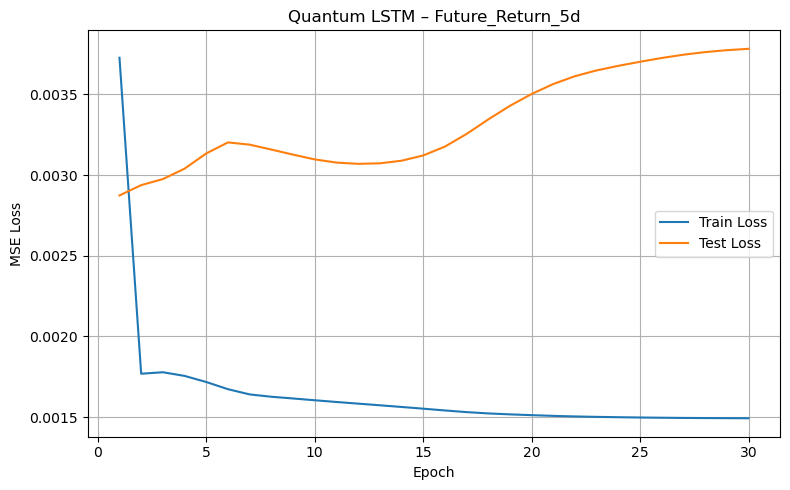

In [27]:
plot_train_test_loss(
    train_losses_qlstm,
    test_losses_qlstm,
    title="Quantum LSTM – Future_Return_5d"
)
